# GNN Explainability: Understanding Why Graph Neural Networks Make Predictions

## NDSU Graduate Course: Graph Data Analytics

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Understand** why explainability matters for GNNs and the unique challenges graphs present
2. **Implement** major explainability methods: GNNExplainer, PGExplainer, and attention-based explanations
3. **Visualize** and interpret explanation outputs (node masks, edge masks, feature importance)
4. **Evaluate** explanation quality using standard metrics (fidelity, unfaithfulness)
5. **Apply** explainability methods to both node and graph classification tasks

---

## Why GNN Explainability Matters

Graph Neural Networks have achieved remarkable success in various domains:
- **Drug Discovery**: Predicting molecular properties
- **Social Networks**: Detecting fraud, recommending connections
- **Financial Systems**: Credit risk assessment
- **Biological Networks**: Protein function prediction

However, GNNs are often **black boxes** - we don't know *why* they make certain predictions. This is problematic because:

1. **Trust**: Users need to understand model decisions
2. **Debugging**: Identifying when models use spurious correlations
3. **Regulatory Compliance**: Many domains require explainable AI
4. **Scientific Discovery**: Understanding *what* the model learned can lead to new insights

---

## 1. Conceptual Framework: The Encoder-Decoder View of Explainability

Following Hamilton's Graph Representation Learning framework, we can view GNN explainability through the **encoder-decoder** lens:

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    GNN PREDICTION PIPELINE                              │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   Input Graph        ENCODER (GNN)         DECODER         Prediction  │
│   ┌─────────┐       ┌───────────────┐    ┌──────────┐     ┌──────────┐ │
│   │  G, X   │ ───▶  │  Message      │ ─▶ │  MLP /   │ ──▶ │    ŷ     │ │
│   │         │       │  Passing      │    │ Softmax  │     │          │ │
│   └─────────┘       │  → Z (embs)   │    └──────────┘     └──────────┘ │
│                     └───────────────┘                                   │
│                                                                         │
├─────────────────────────────────────────────────────────────────────────┤
│                    EXPLAINABILITY QUESTION                              │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   "Which parts of G and X were most important for predicting ŷ?"       │
│                                                                         │
│   ┌─────────────────────────────────────────────────────────────────┐   │
│   │                    EXPLANATION TYPES                            │   │
│   ├─────────────────────────────────────────────────────────────────┤   │
│   │  • Edge Mask: Which edges matter?        (structural)          │   │
│   │  • Node Mask: Which nodes matter?        (structural)          │   │
│   │  • Feature Mask: Which features matter?  (attributional)       │   │
│   └─────────────────────────────────────────────────────────────────┘   │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

### Types of Explanations

| Type | What it explains | Output |
|------|------------------|--------|
| **Edge Mask** | Which connections are important | Weights on edges [0,1] |
| **Node Mask** | Which neighbors matter | Weights on nodes [0,1] |
| **Feature Mask** | Which node features matter | Weights on features [0,1] |

### Instance vs. Model-Level Explanations

- **Instance-level**: Explains a single prediction (e.g., "Why was *this* node classified as class 2?")
- **Model-level**: Explains general model behavior (e.g., "What patterns does the model typically use for class 2?")

---

## 2. Environment Setup

First, let's install the required packages and set up our environment.

In [1]:
# Install required packages
!pip install -q torch torch_geometric matplotlib networkx captum

# Check for GPU availability
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [2]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from collections import defaultdict

# PyTorch Geometric imports
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid, BAShapes
from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, CaptumExplainer
from torch_geometric.explain import unfaithfulness, fidelity
from torch_geometric.explain.config import MaskType, ModelConfig, ModelMode, ModelTaskLevel

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All imports successful!")

/Users/harunpirim/Documents/GitHub/graphframex/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful!


## 3. The BA-Shapes Dataset: A Benchmark for Explainability

The **BA-Shapes** dataset is the gold standard for evaluating GNN explainability methods because it has **ground-truth explanations**.

### Dataset Structure

```
┌───────────────────────────────────────────────────────────────────────┐
│                        BA-SHAPES DATASET                              │
├───────────────────────────────────────────────────────────────────────┤
│                                                                       │
│   Base Graph: Barabási-Albert (BA) model with 300 nodes              │
│   └── Scale-free network with preferential attachment                │
│                                                                       │
│   Motifs: 80 "house" structures (5 nodes each) attached randomly     │
│                                                                       │
│        ┌───┐                                                         │
│        │ T │  ← Top (Class 1)                                        │
│       /     \                                                        │
│    ┌───┐   ┌───┐                                                     │
│    │ M │───│ M │  ← Middle (Class 2)                                 │
│    └───┘   └───┘                                                     │
│      │       │                                                       │
│    ┌───┐   ┌───┐                                                     │
│    │ B │───│ B │  ← Bottom (Class 3)                                 │
│    └───┘   └───┘                                                     │
│                                                                       │
│   Node Classes:                                                       │
│   • Class 0: Base graph nodes (not in any house)                     │
│   • Class 1: Top of house                                            │
│   • Class 2: Middle of house                                         │
│   • Class 3: Bottom of house                                         │
│                                                                       │
│   Ground Truth: The house motif IS the explanation for non-base nodes │
│                                                                       │
└───────────────────────────────────────────────────────────────────────┘
```

### Why BA-Shapes is Perfect for Benchmarking

1. **Known ground truth**: We *know* the house structure determines the label
2. **Clear structural patterns**: Easy to visualize and verify
3. **Multiple classes**: Tests multi-class explanation ability
4. **Noise**: Base graph provides realistic noise to filter out

In [3]:
# Load BA-Shapes dataset
# Note: We'll create a synthetic version since BAShapes may not be directly available

def create_ba_shapes_dataset(num_base_nodes=300, num_houses=80, seed=42):
    """
    Create the BA-Shapes dataset.
    
    The dataset consists of:
    - A Barabási-Albert base graph
    - House-shaped motifs attached to random nodes
    - Node labels based on structural role
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Create BA base graph using NetworkX
    G = nx.barabasi_albert_graph(num_base_nodes, m=5, seed=seed)
    
    # Initialize labels (0 = base node)
    labels = {i: 0 for i in range(num_base_nodes)}
    
    # Track ground truth explanation edges
    ground_truth_edges = set()
    
    current_node = num_base_nodes
    
    # Attach house motifs
    for _ in range(num_houses):
        # Select random node from base graph to attach house
        attach_node = np.random.randint(0, num_base_nodes)
        
        # Create house nodes (5 nodes: 1 top, 2 middle, 2 bottom)
        top = current_node
        mid_left = current_node + 1
        mid_right = current_node + 2
        bot_left = current_node + 3
        bot_right = current_node + 4
        
        # Add nodes
        G.add_nodes_from([top, mid_left, mid_right, bot_left, bot_right])
        
        # Add house edges
        house_edges = [
            (top, mid_left), (top, mid_right),  # Roof
            (mid_left, mid_right),               # Middle connection
            (mid_left, bot_left), (mid_right, bot_right),  # Walls
            (bot_left, bot_right)                # Floor
        ]
        G.add_edges_from(house_edges)
        ground_truth_edges.update(house_edges)
        ground_truth_edges.update([(v, u) for u, v in house_edges])  # Both directions
        
        # Connect house to base graph
        G.add_edge(attach_node, bot_left)
        
        # Assign labels based on structural role
        labels[top] = 1        # Top of house
        labels[mid_left] = 2   # Middle of house
        labels[mid_right] = 2
        labels[bot_left] = 3   # Bottom of house
        labels[bot_right] = 3
        
        current_node += 5
    
    # Convert to PyG format
    edge_index = torch.tensor(list(G.edges())).t().contiguous()
    # Make undirected
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    
    # Create node features (simple one-hot based on degree)
    num_nodes = G.number_of_nodes()
    x = torch.ones(num_nodes, 10)  # Simple constant features
    
    y = torch.tensor([labels[i] for i in range(num_nodes)])
    
    # Create PyG Data object
    from torch_geometric.data import Data
    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_classes = 4
    data.ground_truth_edges = ground_truth_edges
    
    return data, G

# Create dataset
data, G_nx = create_ba_shapes_dataset()
data = data.to(device)

print(f"Dataset Statistics:")
print(f"  Nodes: {data.num_nodes}")
print(f"  Edges: {data.edge_index.shape[1]}")
print(f"  Features: {data.x.shape[1]}")
print(f"  Classes: {data.num_classes}")
print(f"\nLabel distribution:")
for i in range(4):
    count = (data.y == i).sum().item()
    print(f"  Class {i}: {count} nodes")

Dataset Statistics:
  Nodes: 700
  Edges: 4070
  Features: 10
  Classes: 4

Label distribution:
  Class 0: 300 nodes
  Class 1: 80 nodes
  Class 2: 160 nodes
  Class 3: 160 nodes


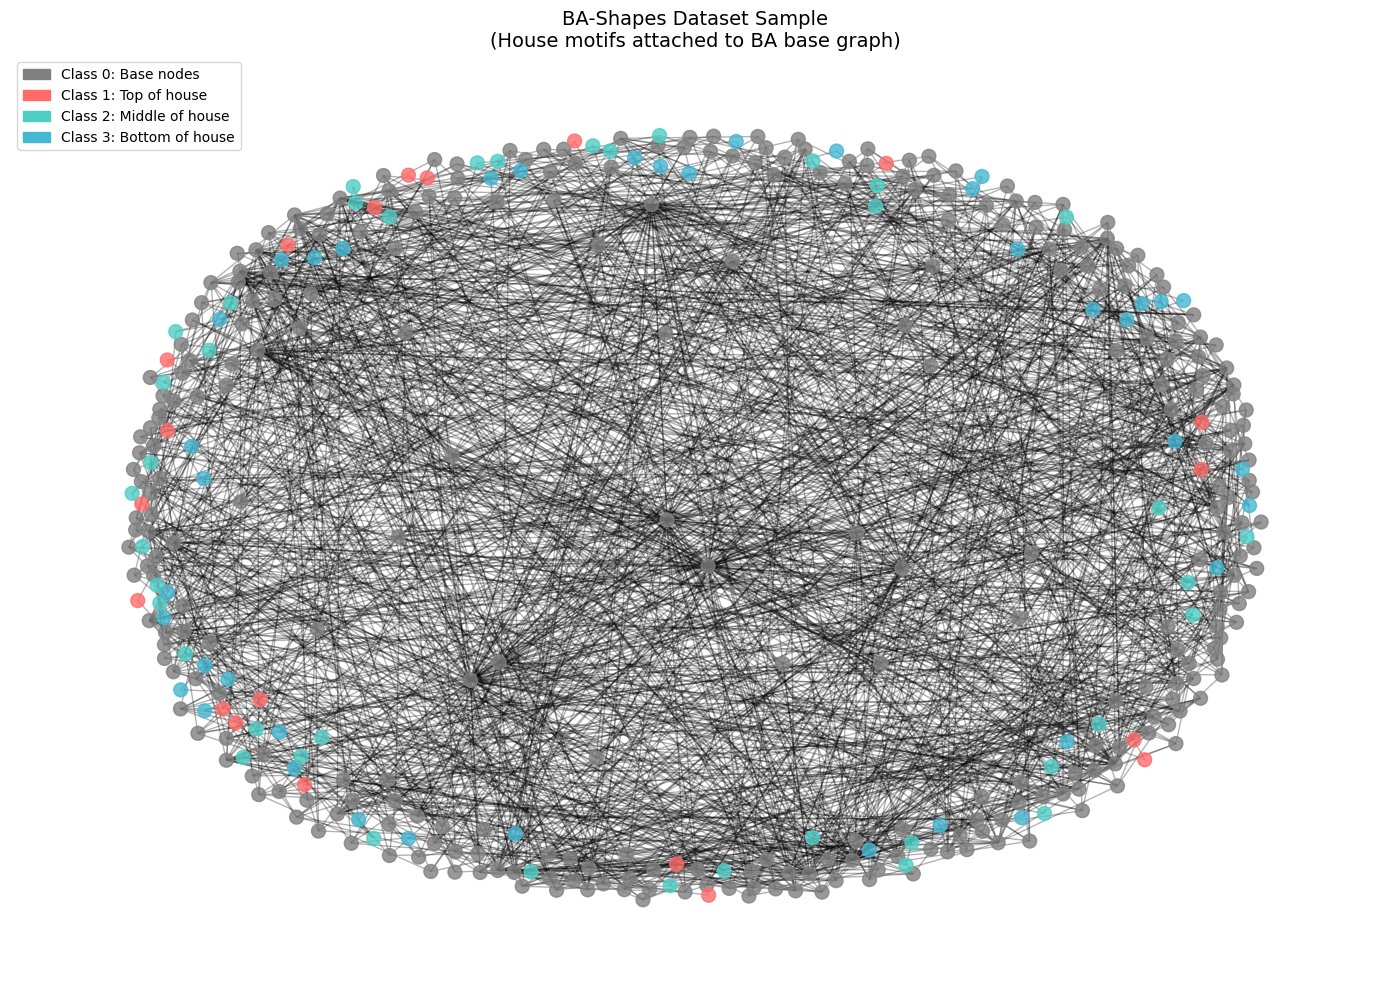

In [4]:
# Visualize a portion of the BA-Shapes graph

def visualize_ba_shapes_sample(G_nx, labels, num_nodes_to_show=100):
    """
    Visualize a sample of the BA-Shapes graph highlighting the house motifs.
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get subgraph of first num_nodes_to_show nodes
    nodes = list(range(min(num_nodes_to_show, G_nx.number_of_nodes())))
    subG = G_nx.subgraph(nodes)
    
    # Color map for classes
    color_map = {
        0: '#808080',  # Gray - base nodes
        1: '#FF6B6B',  # Red - top of house
        2: '#4ECDC4',  # Teal - middle of house
        3: '#45B7D1'   # Blue - bottom of house
    }
    
    labels_dict = {i: labels[i].item() if hasattr(labels[i], 'item') else labels[i] 
                   for i in nodes if i < len(labels)}
    node_colors = [color_map.get(labels_dict.get(n, 0), '#808080') for n in subG.nodes()]
    
    # Layout
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    # Draw
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=100, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subG, pos, alpha=0.3, ax=ax)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color='#808080', label='Class 0: Base nodes'),
        mpatches.Patch(color='#FF6B6B', label='Class 1: Top of house'),
        mpatches.Patch(color='#4ECDC4', label='Class 2: Middle of house'),
        mpatches.Patch(color='#45B7D1', label='Class 3: Bottom of house')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    ax.set_title('BA-Shapes Dataset Sample\n(House motifs attached to BA base graph)', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize
visualize_ba_shapes_sample(G_nx, data.y.cpu().numpy(), num_nodes_to_show=400)

## 4. Building a GNN Model to Explain

Before we can explain predictions, we need a trained GNN model. We'll use a 2-layer GCN for node classification.

### GCN Architecture Recap (from GRL Book)

The GCN message passing is defined as:

$$h_u^{(k)} = \sigma\left(W^{(k)} \sum_{v \in \mathcal{N}(u) \cup \{u\}} \frac{h_v^{(k-1)}}{\sqrt{|\mathcal{N}(u)||\mathcal{N}(v)|}}\right)$$

This symmetric normalization helps with numerical stability and can be motivated from spectral graph theory.

In [5]:
class GCN_2Layer(nn.Module):
    """
    2-Layer Graph Convolutional Network for node classification.
    
    Architecture:
        Input → GCNConv → ReLU → Dropout → GCNConv → LogSoftmax
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# Initialize model
model = GCN_2Layer(
    in_channels=data.x.shape[1],
    hidden_channels=64,
    out_channels=data.num_classes,
    dropout=0.3
).to(device)

print(model)

GCN_2Layer(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 4)
)


In [6]:
# Train the GCN model

def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    """
    Train the GNN model for node classification.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Create train/val/test masks
    num_nodes = data.num_nodes
    perm = torch.randperm(num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[perm[:int(0.6*num_nodes)]] = True
    val_mask[perm[int(0.6*num_nodes):int(0.8*num_nodes)]] = True
    test_mask[perm[int(0.8*num_nodes):]] = True
    
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    test_mask = test_mask.to(device)
    
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        
        loss.backward()
        optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            pred = model(data.x, data.edge_index).argmax(dim=1)
            train_acc = (pred[train_mask] == data.y[train_mask]).float().mean().item()
            val_acc = (pred[val_mask] == data.y[val_mask]).float().mean().item()
        
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    # Final test accuracy
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        test_acc = (pred[test_mask] == data.y[test_mask]).float().mean().item()
    
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    
    return history, test_mask

# Train
history, test_mask = train_model(model, data)

Epoch  50 | Loss: 1.2809 | Train Acc: 0.4119 | Val Acc: 0.4786
Epoch 100 | Loss: 1.0627 | Train Acc: 0.7571 | Val Acc: 0.7857
Epoch 150 | Loss: 0.8425 | Train Acc: 0.8405 | Val Acc: 0.8857
Epoch 200 | Loss: 0.7293 | Train Acc: 0.8429 | Val Acc: 0.8857

Final Test Accuracy: 0.8500


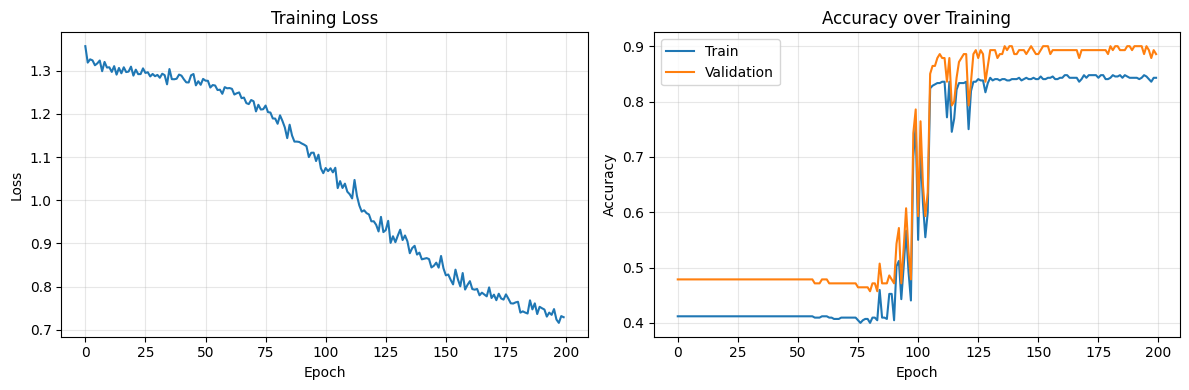

In [7]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. GNNExplainer: Perturbation-Based Explanations

**GNNExplainer** (Ying et al., NeurIPS 2019) is the foundational method for GNN explainability. It identifies important subgraph structures and node features by learning soft masks.

### The Key Idea

For a given node $v$ and its prediction $\hat{y}_v$, GNNExplainer finds:
1. A subgraph $G_S \subseteq G$ (the important edges/nodes)
2. Feature mask $X_S$ (the important features)

such that the prediction remains similar when using only $G_S$ and $X_S$.

### Mathematical Formulation

GNNExplainer maximizes **mutual information** between the explanation and the prediction:

$$\max_{G_S} MI(Y, (G_S, X_S)) = H(Y) - H(Y | G = G_S, X = X_S)$$

In practice, this is done by:
1. Learning continuous edge mask $M \in [0,1]^{|E|}$
2. Learning continuous feature mask $M_F \in [0,1]^{d}$
3. Optimizing via gradient descent with sparsity regularization

### Loss Function

$$\mathcal{L} = -\log P_\phi(Y = y | G \odot \sigma(M)) + \lambda_1 ||M||_1 + \lambda_2 H(M)$$

Where:
- First term: Cross-entropy with masked graph
- $\lambda_1 ||M||_1$: Sparsity regularization (want few edges)
- $\lambda_2 H(M)$: Entropy regularization (want decisive masks, not ambiguous)

```
┌─────────────────────────────────────────────────────────────────────────┐
│                     GNNExplainer WORKFLOW                              │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   Step 1: Get prediction ŷ for target node v                           │
│                                                                         │
│   Step 2: Initialize learnable masks M (edges) and M_F (features)      │
│                                                                         │
│   Step 3: For each optimization step:                                  │
│           • Apply masks: G_masked = G ⊙ σ(M)                           │
│           • Get new prediction: ŷ_masked = f(G_masked, X ⊙ σ(M_F))    │
│           • Compute loss: L = -log(ŷ_masked[y]) + regularization      │
│           • Update M, M_F via gradient descent                         │
│                                                                         │
│   Step 4: Return final masks (high values = important)                 │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

In [8]:
# Set up GNNExplainer using PyG's explain module

# Configure the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200, lr=0.01),
    explanation_type='model',  # Explain model's predictions
    node_mask_type='attributes',  # Learn feature importance
    edge_mask_type='object',  # Learn edge importance
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

print("GNNExplainer configured!")
print(f"\nExplanation type: {explainer.explanation_type}")
print(f"Node mask type: {explainer.node_mask_type}")
print(f"Edge mask type: {explainer.edge_mask_type}")

GNNExplainer configured!

Explanation type: ExplanationType.model
Node mask type: MaskType.attributes
Edge mask type: MaskType.object


In [9]:
# Find a good node to explain (one in a house motif with correct prediction)

model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index).argmax(dim=1)

# Find correctly classified house nodes
correct_house_nodes = []
for node_idx in range(data.num_nodes):
    true_label = data.y[node_idx].item()
    pred_label = predictions[node_idx].item()
    if true_label > 0 and true_label == pred_label:  # House node, correctly classified
        correct_house_nodes.append((node_idx, true_label))

print(f"Found {len(correct_house_nodes)} correctly classified house nodes")

# Select one from each class
example_nodes = {}
for node_idx, label in correct_house_nodes:
    if label not in example_nodes:
        example_nodes[label] = node_idx

print("\nExample nodes for explanation:")
for label, node_idx in sorted(example_nodes.items()):
    class_names = ['Base', 'Top', 'Middle', 'Bottom']
    print(f"  Class {label} ({class_names[label]}): Node {node_idx}")

Found 312 correctly classified house nodes

Example nodes for explanation:
  Class 2 (Middle): Node 301
  Class 3 (Bottom): Node 303


In [10]:
# Generate explanation for a house node

# Pick a "middle of house" node (class 2) - has clear structural context
target_node = example_nodes.get(2, correct_house_nodes[0][0])

print(f"Generating explanation for node {target_node}...")
print(f"True label: {data.y[target_node].item()} (Middle of house)")

# Generate explanation
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    index=target_node,
)

print(f"\nExplanation generated!")
print(f"Edge mask shape: {explanation.edge_mask.shape}")
if explanation.node_mask is not None:
    print(f"Node/Feature mask shape: {explanation.node_mask.shape}")

Generating explanation for node 301...
True label: 2 (Middle of house)

Explanation generated!
Edge mask shape: torch.Size([4070])
Node/Feature mask shape: torch.Size([700, 10])


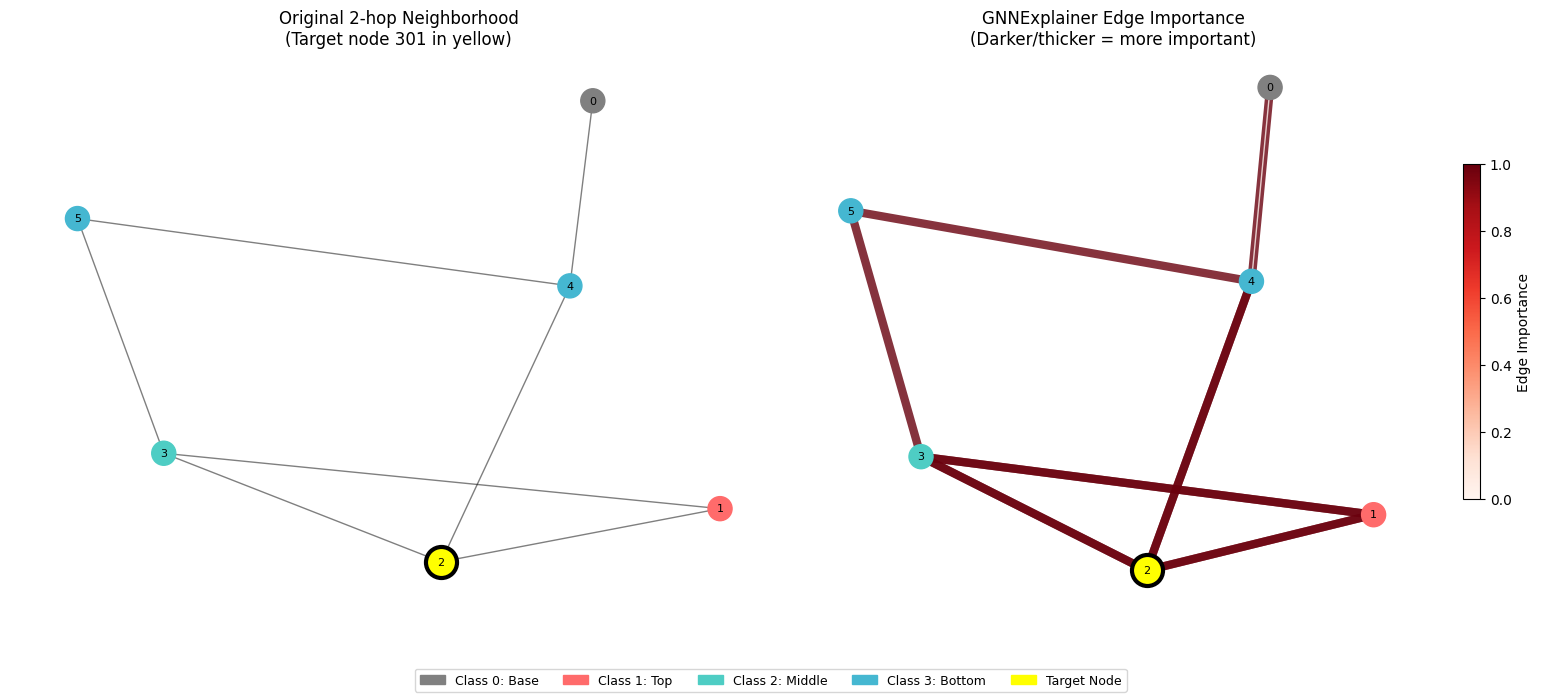


Top 10 Most Important Edges:
  1. Edge (300 → 302): importance = 1.0000
  2. Edge (301 → 302): importance = 0.9974
  3. Edge (304 → 302): importance = 0.9965
  4. Edge (102 → 303): importance = 0.9959
  5. Edge (304 → 303): importance = 0.9953
  6. Edge (301 → 303): importance = 0.9928
  7. Edge (301 → 300): importance = 0.9913
  8. Edge (302 → 300): importance = 0.9904
  9. Edge (303 → 301): importance = 0.9899
  10. Edge (302 → 301): importance = 0.9896


In [11]:
# Visualize the explanation

def visualize_explanation(data, explanation, target_node, G_nx, num_hops=2):
    """
    Visualize GNNExplainer results showing important edges.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Get k-hop subgraph around target node
    subset, sub_edge_index, mapping, edge_mask_idx = k_hop_subgraph(
        target_node, num_hops, data.edge_index, relabel_nodes=True
    )
    
    target_in_sub = mapping.item()
    subset = subset.cpu().numpy()
    sub_edge_index = sub_edge_index.cpu().numpy()
    
    # Create subgraph
    subG = nx.Graph()
    subG.add_nodes_from(range(len(subset)))
    edges = list(zip(sub_edge_index[0], sub_edge_index[1]))
    subG.add_edges_from(edges)
    
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    # Get edge importance from explanation
    edge_mask = explanation.edge_mask.cpu().numpy()
    sub_edge_importance = edge_mask[edge_mask_idx.cpu().numpy()]
    
    # Normalize edge importance
    if sub_edge_importance.max() > 0:
        sub_edge_importance = sub_edge_importance / sub_edge_importance.max()
    
    # Color map for node classes
    color_map = {0: '#808080', 1: '#FF6B6B', 2: '#4ECDC4', 3: '#45B7D1'}
    node_colors = [color_map[data.y[subset[i]].item()] for i in range(len(subset))]
    
    # Left plot: Original subgraph
    ax = axes[0]
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, ax=ax)
    nx.draw_networkx_nodes(subG, pos, nodelist=[target_in_sub], node_color='yellow', 
                          node_size=500, linewidths=3, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(subG, pos, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
    ax.set_title(f'Original {num_hops}-hop Neighborhood\n(Target node {target_node} in yellow)', fontsize=12)
    ax.axis('off')
    
    # Right plot: Explanation (edge importance)
    ax = axes[1]
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, ax=ax)
    nx.draw_networkx_nodes(subG, pos, nodelist=[target_in_sub], node_color='yellow', 
                          node_size=500, linewidths=3, edgecolors='black', ax=ax)
    
    # Draw edges with importance-based width and color
    edge_colors = plt.cm.Reds(sub_edge_importance)
    edge_widths = 1 + 5 * sub_edge_importance
    
    for idx, (u, v) in enumerate(edges):
        nx.draw_networkx_edges(subG, pos, edgelist=[(u, v)], 
                              width=edge_widths[idx],
                              edge_color=[edge_colors[idx]],
                              alpha=0.8, ax=ax)
    
    nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
    ax.set_title(f'GNNExplainer Edge Importance\n(Darker/thicker = more important)', fontsize=12)
    ax.axis('off')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[1], shrink=0.6)
    cbar.set_label('Edge Importance', fontsize=10)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color='#808080', label='Class 0: Base'),
        mpatches.Patch(color='#FF6B6B', label='Class 1: Top'),
        mpatches.Patch(color='#4ECDC4', label='Class 2: Middle'),
        mpatches.Patch(color='#45B7D1', label='Class 3: Bottom'),
        mpatches.Patch(color='yellow', label='Target Node')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=9)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()
    
    # Print top important edges
    print("\nTop 10 Most Important Edges:")
    edge_importance_list = [(edges[i], sub_edge_importance[i]) for i in range(len(edges))]
    edge_importance_list.sort(key=lambda x: x[1], reverse=True)
    
    for i, ((u, v), imp) in enumerate(edge_importance_list[:10]):
        orig_u = subset[u]
        orig_v = subset[v]
        print(f"  {i+1}. Edge ({orig_u} → {orig_v}): importance = {imp:.4f}")

# Visualize
visualize_explanation(data, explanation, target_node, G_nx)

## 6. PGExplainer: Parameterized Explainer

**PGExplainer** (Luo et al., NeurIPS 2020) addresses a key limitation of GNNExplainer: it trains a **single explainer network** that can explain multiple instances, rather than optimizing separately for each instance.

### Key Differences from GNNExplainer

| Aspect | GNNExplainer | PGExplainer |
|--------|--------------|-------------|
| Optimization | Per-instance | Global (trained once) |
| Speed at inference | Slow (requires optimization) | Fast (feed-forward) |
| Generalization | N/A | Can explain unseen instances |
| Consistency | Can vary between runs | More consistent |

### Architecture

PGExplainer uses an MLP to generate edge masks from node embeddings:

$$\omega_{ij} = \text{MLP}_\Psi([z_i; z_j])$$

Where $z_i, z_j$ are node embeddings and $\omega_{ij}$ is the edge probability.

```
┌─────────────────────────────────────────────────────────────────────────┐
│                      PGExplainer ARCHITECTURE                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   Training Phase (once):                                               │
│   ┌───────────────────────────────────────────────────────────────┐   │
│   │  For many training nodes:                                      │   │
│   │  1. Get node embeddings z_i, z_j from GNN                     │   │
│   │  2. Compute edge prob: ω_ij = MLP_Ψ([z_i; z_j])              │   │
│   │  3. Sample edge mask from Bernoulli(ω_ij)                     │   │
│   │  4. Compute loss and update Ψ                                 │   │
│   └───────────────────────────────────────────────────────────────┘   │
│                                                                         │
│   Inference Phase (fast):                                              │
│   ┌───────────────────────────────────────────────────────────────┐   │
│   │  For new node v:                                               │   │
│   │  1. Get embeddings → MLP_Ψ → edge masks (single forward pass) │   │
│   └───────────────────────────────────────────────────────────────┘   │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

In [12]:
# Set up and train PGExplainer

# PGExplainer needs to be trained on the graph first
pg_explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',  # Explain the underlying phenomenon
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

print("Training PGExplainer...")

# Train on a sample of nodes
train_indices = torch.randperm(data.num_nodes)[:200]

for epoch in range(30):
    for i in range(0, len(train_indices), 32):
        batch_indices = train_indices[i:i+32]
        for idx in batch_indices:
            loss = pg_explainer.algorithm.train(
                epoch=epoch,
                model=model,
                x=data.x,
                edge_index=data.edge_index,
                target=data.y,
                index=idx.item(),
            )
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/30 completed")

print("PGExplainer training complete!")

Training PGExplainer...


/Users/harunpirim/Documents/GitHub/graphframex/venv/lib/python3.13/site-packages/torch_geometric/explain/algorithm/pg_explainer.py:224: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  return float(loss)


Epoch 10/30 completed
Epoch 20/30 completed
Epoch 30/30 completed
PGExplainer training complete!


In [13]:
# Generate explanation using trained PGExplainer

print(f"\nGenerating PGExplainer explanation for node {target_node}...")

pg_explanation = pg_explainer(
    x=data.x,
    edge_index=data.edge_index,
    target=data.y,
    index=target_node,
)

print(f"Edge mask shape: {pg_explanation.edge_mask.shape}")


Generating PGExplainer explanation for node 301...
Edge mask shape: torch.Size([4070])


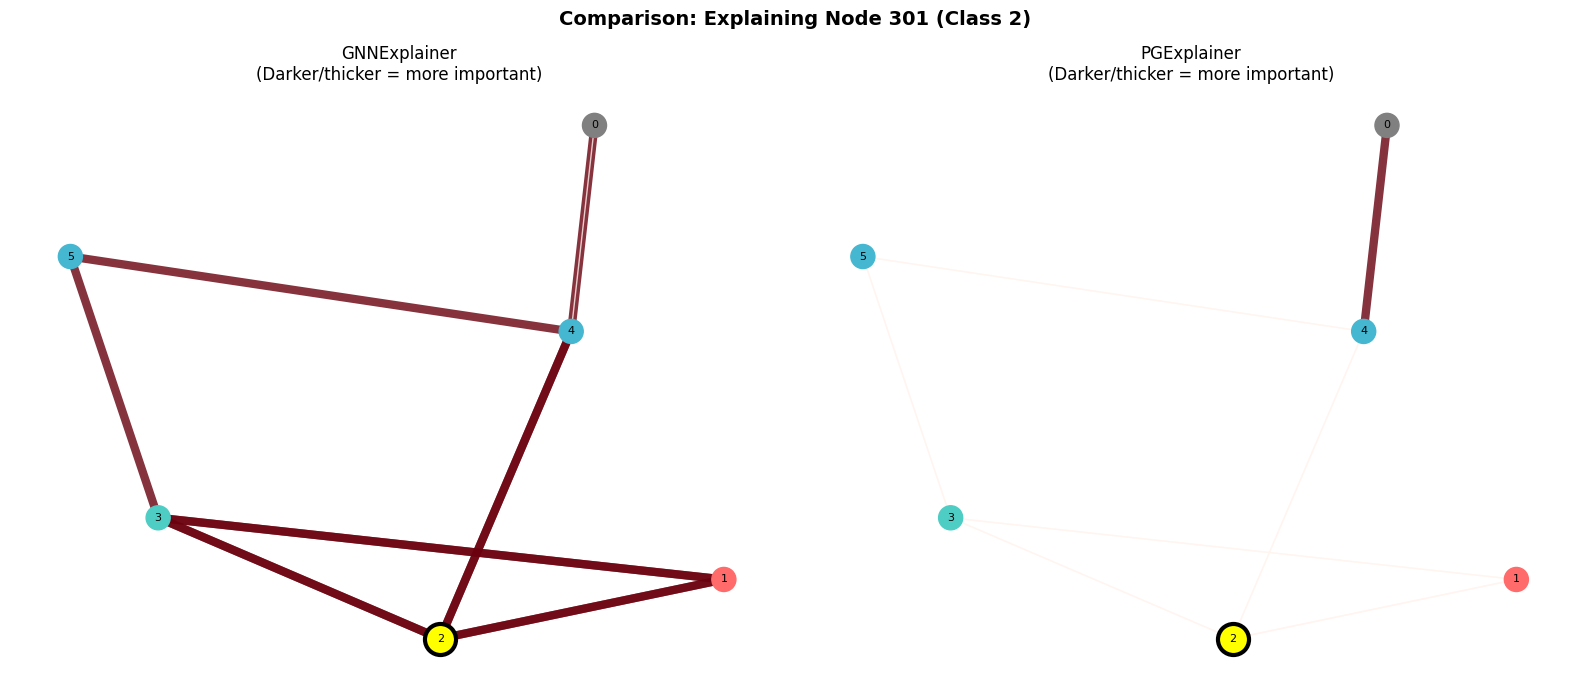

In [14]:
# Compare GNNExplainer vs PGExplainer

def compare_explanations(data, gnn_exp, pg_exp, target_node, num_hops=2):
    """
    Compare explanations from GNNExplainer and PGExplainer side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Get k-hop subgraph
    subset, sub_edge_index, mapping, edge_mask_idx = k_hop_subgraph(
        target_node, num_hops, data.edge_index, relabel_nodes=True
    )
    
    target_in_sub = mapping.item()
    subset = subset.cpu().numpy()
    sub_edge_index = sub_edge_index.cpu().numpy()
    
    subG = nx.Graph()
    subG.add_nodes_from(range(len(subset)))
    edges = list(zip(sub_edge_index[0], sub_edge_index[1]))
    subG.add_edges_from(edges)
    
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    color_map = {0: '#808080', 1: '#FF6B6B', 2: '#4ECDC4', 3: '#45B7D1'}
    node_colors = [color_map[data.y[subset[i]].item()] for i in range(len(subset))]
    
    explanations = [
        (gnn_exp, 'GNNExplainer'),
        (pg_exp, 'PGExplainer')
    ]
    
    for ax_idx, (exp, name) in enumerate(explanations):
        ax = axes[ax_idx]
        
        edge_mask = exp.edge_mask.cpu().numpy()
        sub_edge_importance = edge_mask[edge_mask_idx.cpu().numpy()]
        
        if sub_edge_importance.max() > 0:
            sub_edge_importance = sub_edge_importance / sub_edge_importance.max()
        
        nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, ax=ax)
        nx.draw_networkx_nodes(subG, pos, nodelist=[target_in_sub], node_color='yellow', 
                              node_size=500, linewidths=3, edgecolors='black', ax=ax)
        
        edge_colors = plt.cm.Reds(sub_edge_importance)
        edge_widths = 1 + 5 * sub_edge_importance
        
        for idx, (u, v) in enumerate(edges):
            nx.draw_networkx_edges(subG, pos, edgelist=[(u, v)], 
                                  width=edge_widths[idx],
                                  edge_color=[edge_colors[idx]],
                                  alpha=0.8, ax=ax)
        
        nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
        ax.set_title(f'{name}\n(Darker/thicker = more important)', fontsize=12)
        ax.axis('off')
    
    plt.suptitle(f'Comparison: Explaining Node {target_node} (Class {data.y[target_node].item()})', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compare
compare_explanations(data, explanation, pg_explanation, target_node)

## 7. Attention-Based Explanations

For attention-based GNNs (GAT, GATv2, Transformer), the learned attention coefficients provide a **built-in** form of explanation.

### The Intuition

In GAT, each edge $(u, v)$ has an attention coefficient $\alpha_{uv}$ that determines how much node $v$'s features contribute to node $u$'s updated embedding:

$$h_u' = \sigma\left(\sum_{v \in \mathcal{N}(u)} \alpha_{uv} W h_v\right)$$

Where attention is computed as:

$$\alpha_{uv} = \text{softmax}_v\left(\text{LeakyReLU}(a^T [Wh_u || Wh_v])\right)$$

### Advantages and Limitations

**Advantages:**
- No additional computation needed
- Integrated into the model
- Can be analyzed per layer

**Limitations:**
- Attention may not reflect true importance
- Works only for attention-based architectures
- May learn spurious patterns

In [15]:
# Build a GAT model for attention-based explanations

class GAT_2Layer(nn.Module):
    """
    2-Layer Graph Attention Network.
    Stores attention weights for explanation.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, 
                            concat=False, dropout=dropout)
        self.dropout = dropout
        
        # Storage for attention weights
        self.attention_weights = {}
        
    def forward(self, x, edge_index, return_attention=False):
        # First GAT layer with attention
        x, (edge_index1, alpha1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GAT layer with attention
        x, (edge_index2, alpha2) = self.conv2(x, edge_index, return_attention_weights=True)
        
        if return_attention:
            self.attention_weights = {
                'layer1': (edge_index1, alpha1),
                'layer2': (edge_index2, alpha2)
            }
        
        return F.log_softmax(x, dim=1)

# Initialize GAT
gat_model = GAT_2Layer(
    in_channels=data.x.shape[1],
    hidden_channels=16,
    out_channels=data.num_classes,
    heads=4,
    dropout=0.3
).to(device)

print(gat_model)

GAT_2Layer(
  (conv1): GATConv(10, 16, heads=4)
  (conv2): GATConv(64, 4, heads=1)
)


In [16]:
# Train GAT model

def train_gat(model, data, epochs=200, lr=0.005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    # Use same masks as before
    num_nodes = data.num_nodes
    perm = torch.randperm(num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm[:int(0.6*num_nodes)]] = True
    train_mask = train_mask.to(device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                pred = model(data.x, data.edge_index).argmax(dim=1)
                acc = (pred[train_mask] == data.y[train_mask]).float().mean().item()
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Train Acc: {acc:.4f}")
    
    return model

gat_model = train_gat(gat_model, data)
print("GAT training complete!")

Epoch  50 | Loss: 1.2813 | Train Acc: 0.4381
Epoch 100 | Loss: 1.2659 | Train Acc: 0.4381
Epoch 150 | Loss: 1.2675 | Train Acc: 0.4381
Epoch 200 | Loss: 1.2727 | Train Acc: 0.4381
GAT training complete!


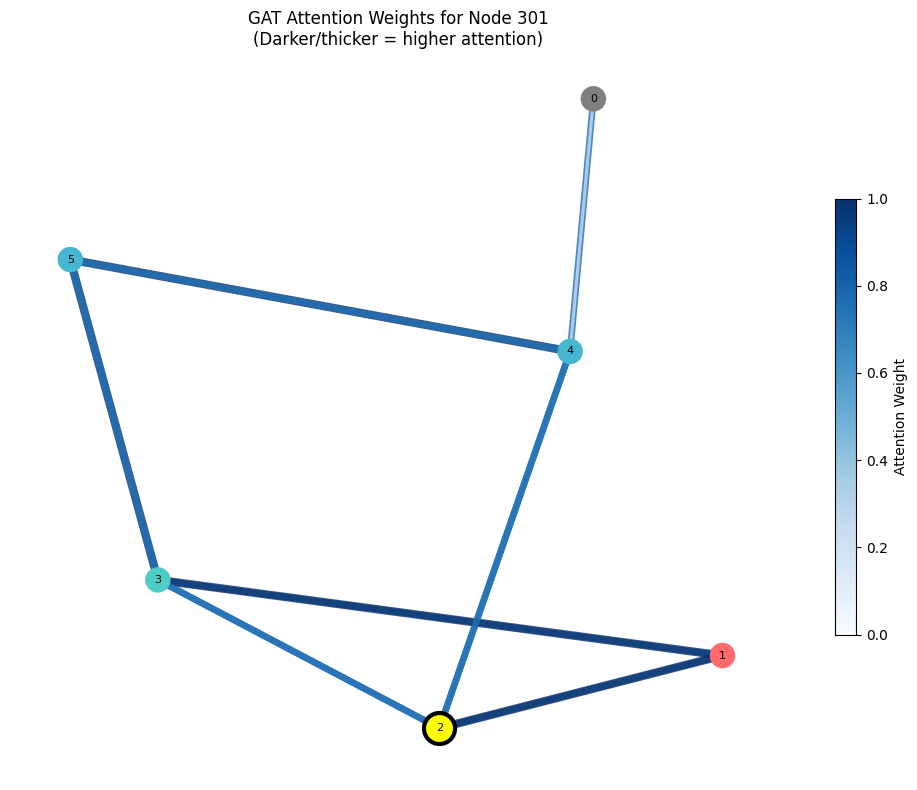

In [17]:
# Get and visualize attention weights

def visualize_attention(model, data, target_node, num_hops=2):
    """
    Visualize GAT attention weights as edge importance.
    """
    model.eval()
    with torch.no_grad():
        _ = model(data.x, data.edge_index, return_attention=True)
    
    # Get attention from layer 2 (final layer)
    edge_index_att, attention = model.attention_weights['layer2']
    attention = attention.squeeze().cpu().numpy()  # Average over heads if needed
    edge_index_att = edge_index_att.cpu().numpy()
    
    # Get k-hop subgraph
    subset, sub_edge_index, mapping, edge_mask_idx = k_hop_subgraph(
        target_node, num_hops, data.edge_index, relabel_nodes=True
    )
    
    target_in_sub = mapping.item()
    subset = subset.cpu().numpy()
    sub_edge_index_np = sub_edge_index.cpu().numpy()
    
    # Create mapping from original edge to attention
    edge_to_att = {}
    for i in range(edge_index_att.shape[1]):
        u, v = edge_index_att[0, i], edge_index_att[1, i]
        edge_to_att[(u, v)] = attention[i]
    
    # Create subgraph
    subG = nx.Graph()
    subG.add_nodes_from(range(len(subset)))
    edges = list(zip(sub_edge_index_np[0], sub_edge_index_np[1]))
    subG.add_edges_from(edges)
    
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    # Get attention for edges in subgraph
    sub_attention = []
    for u, v in edges:
        orig_u, orig_v = subset[u], subset[v]
        att = edge_to_att.get((orig_u, orig_v), 0)
        sub_attention.append(att)
    sub_attention = np.array(sub_attention)
    
    if sub_attention.max() > 0:
        sub_attention = sub_attention / sub_attention.max()
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    color_map = {0: '#808080', 1: '#FF6B6B', 2: '#4ECDC4', 3: '#45B7D1'}
    node_colors = [color_map[data.y[subset[i]].item()] for i in range(len(subset))]
    
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, ax=ax)
    nx.draw_networkx_nodes(subG, pos, nodelist=[target_in_sub], node_color='yellow', 
                          node_size=500, linewidths=3, edgecolors='black', ax=ax)
    
    edge_colors = plt.cm.Blues(sub_attention)
    edge_widths = 1 + 5 * sub_attention
    
    for idx, (u, v) in enumerate(edges):
        nx.draw_networkx_edges(subG, pos, edgelist=[(u, v)], 
                              width=edge_widths[idx],
                              edge_color=[edge_colors[idx]],
                              alpha=0.8, ax=ax)
    
    nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
    ax.set_title(f'GAT Attention Weights for Node {target_node}\n(Darker/thicker = higher attention)', 
                fontsize=12)
    ax.axis('off')
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Attention Weight', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Visualize attention
visualize_attention(gat_model, data, target_node)

## 8. Evaluating Explanation Quality

How do we know if an explanation is good? PyG provides several metrics:

### 8.1 Fidelity

**Fidelity** measures whether the explanation actually captures the important parts:

- **Fidelity+** (sufficiency): Does keeping only the explanation preserve the prediction?
- **Fidelity-** (comprehensiveness): Does removing the explanation change the prediction?

$$\text{Fidelity}^+ = f(G_S) \approx f(G)$$
$$\text{Fidelity}^- = f(G \setminus G_S) \neq f(G)$$

### 8.2 Unfaithfulness

**Unfaithfulness** measures how much the model's prediction changes when only using the explanation:

$$\text{Unfaithfulness} = |f(G) - f(G \odot M)|$$

Lower is better (explanation should preserve prediction).

In [18]:
# Evaluate explanation quality

def evaluate_explanations(explainer, explanation, data, target_node):
    """
    Compute various metrics to evaluate explanation quality.
    """
    print(f"\n{'='*60}")
    print(f"EXPLANATION QUALITY METRICS FOR NODE {target_node}")
    print(f"{'='*60}\n")
    
    # Basic statistics about the explanation
    edge_mask = explanation.edge_mask.cpu().numpy()
    
    print("Edge Mask Statistics:")
    print(f"  Total edges: {len(edge_mask)}")
    print(f"  Mean importance: {edge_mask.mean():.4f}")
    print(f"  Std importance: {edge_mask.std():.4f}")
    print(f"  Max importance: {edge_mask.max():.4f}")
    print(f"  Min importance: {edge_mask.min():.4f}")
    
    # Count edges above different thresholds
    for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
        count = (edge_mask > threshold).sum()
        pct = count / len(edge_mask) * 100
        print(f"  Edges > {threshold}: {count} ({pct:.1f}%)")
    
    # Compute unfaithfulness if available
    try:
        unfaith = unfaithfulness(explainer, explanation)
        print(f"\nUnfaithfulness: {unfaith:.4f}")
        print("  (Lower is better - prediction should be preserved)")
    except Exception as e:
        print(f"\nCould not compute unfaithfulness: {e}")
    
    return edge_mask

# Evaluate GNNExplainer explanation
edge_mask = evaluate_explanations(explainer, explanation, data, target_node)


EXPLANATION QUALITY METRICS FOR NODE 301

Edge Mask Statistics:
  Total edges: 4070
  Mean importance: 0.0025
  Std importance: 0.0473
  Max importance: 0.9169
  Min importance: 0.0000
  Edges > 0.1: 11 (0.3%)
  Edges > 0.3: 11 (0.3%)
  Edges > 0.5: 11 (0.3%)
  Edges > 0.7: 11 (0.3%)
  Edges > 0.9: 10 (0.2%)

Unfaithfulness: 0.1707
  (Lower is better - prediction should be preserved)


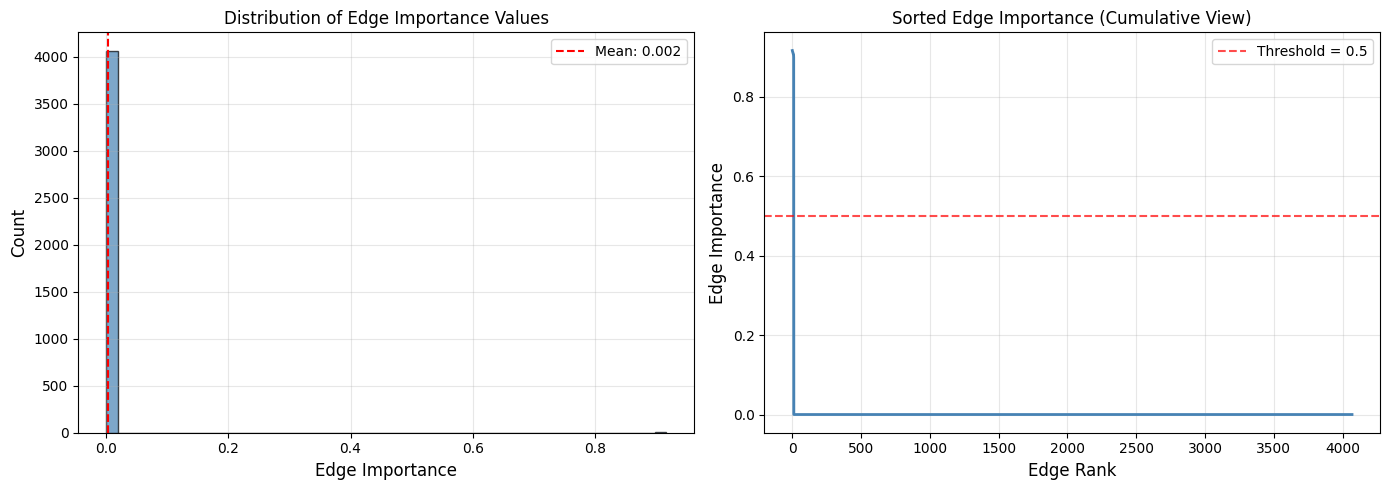

In [19]:
# Visualization: Edge importance distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(edge_mask, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=edge_mask.mean(), color='red', linestyle='--', label=f'Mean: {edge_mask.mean():.3f}')
ax.set_xlabel('Edge Importance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Edge Importance Values', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Sorted edge importance
ax = axes[1]
sorted_mask = np.sort(edge_mask)[::-1]
ax.plot(sorted_mask, color='steelblue', linewidth=2)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold = 0.5')
ax.fill_between(range(len(sorted_mask)), sorted_mask, alpha=0.3)
ax.set_xlabel('Edge Rank', fontsize=12)
ax.set_ylabel('Edge Importance', fontsize=12)
ax.set_title('Sorted Edge Importance (Cumulative View)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Explaining Multiple Nodes: Class-Level Patterns

Let's see if the explainer finds consistent patterns for nodes of the same class.

In [20]:
# Generate explanations for multiple nodes of each class

def explain_class_patterns(explainer, data, model, num_samples_per_class=5):
    """
    Generate explanations for multiple nodes and analyze class patterns.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index).argmax(dim=1)
    
    class_explanations = defaultdict(list)
    
    for class_id in range(1, 4):  # Only house classes (1, 2, 3)
        # Find correctly classified nodes of this class
        class_nodes = []
        for i in range(data.num_nodes):
            if data.y[i].item() == class_id and predictions[i].item() == class_id:
                class_nodes.append(i)
        
        # Sample nodes
        sample_nodes = class_nodes[:min(num_samples_per_class, len(class_nodes))]
        
        print(f"\nClass {class_id}: Explaining {len(sample_nodes)} nodes...")
        
        for node_idx in sample_nodes:
            try:
                exp = explainer(
                    x=data.x,
                    edge_index=data.edge_index,
                    index=node_idx,
                )
                class_explanations[class_id].append({
                    'node': node_idx,
                    'edge_mask': exp.edge_mask.cpu().numpy()
                })
            except Exception as e:
                print(f"  Error explaining node {node_idx}: {e}")
    
    return class_explanations

# Generate class explanations
class_explanations = explain_class_patterns(explainer, data, model, num_samples_per_class=5)


Class 1: Explaining 0 nodes...

Class 2: Explaining 5 nodes...

Class 3: Explaining 5 nodes...


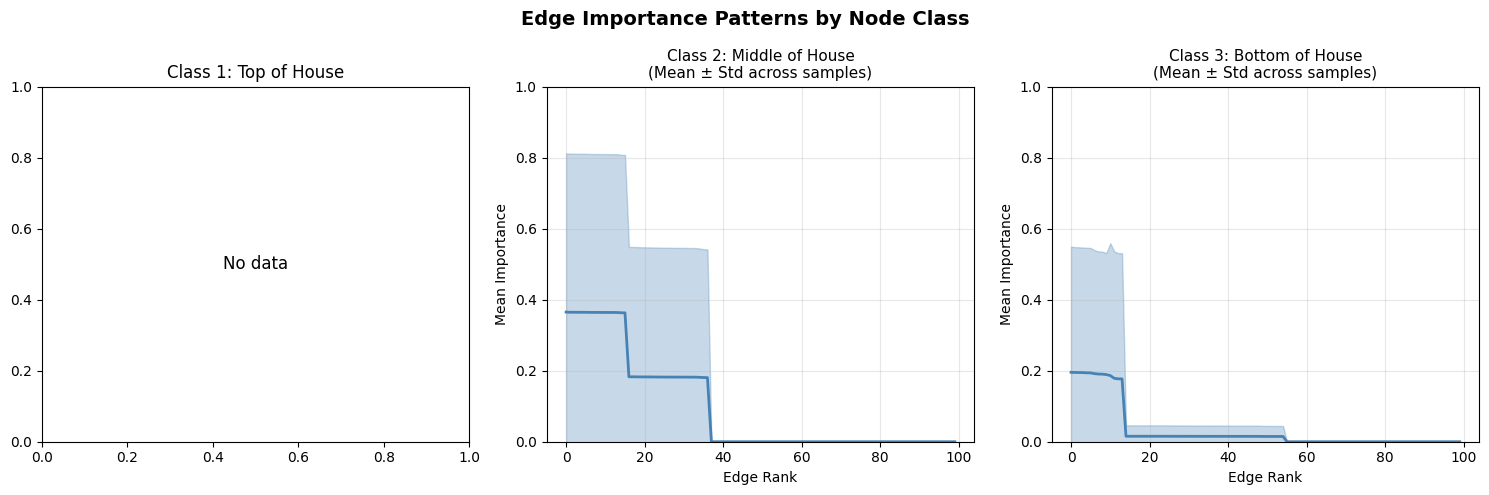

In [21]:
# Analyze and visualize class-level explanation patterns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

class_names = {1: 'Top of House', 2: 'Middle of House', 3: 'Bottom of House'}

for idx, class_id in enumerate([1, 2, 3]):
    ax = axes[idx]
    
    if class_id in class_explanations and len(class_explanations[class_id]) > 0:
        # Stack all edge masks for this class
        all_masks = np.stack([exp['edge_mask'] for exp in class_explanations[class_id]])
        
        # Compute statistics
        mean_mask = all_masks.mean(axis=0)
        std_mask = all_masks.std(axis=0)
        
        # Sort by mean importance
        sorted_idx = np.argsort(mean_mask)[::-1]
        sorted_mean = mean_mask[sorted_idx][:100]  # Top 100 edges
        sorted_std = std_mask[sorted_idx][:100]
        
        # Plot
        x = np.arange(len(sorted_mean))
        ax.fill_between(x, sorted_mean - sorted_std, sorted_mean + sorted_std, 
                       alpha=0.3, color='steelblue')
        ax.plot(x, sorted_mean, color='steelblue', linewidth=2)
        
        ax.set_xlabel('Edge Rank', fontsize=10)
        ax.set_ylabel('Mean Importance', fontsize=10)
        ax.set_title(f'Class {class_id}: {class_names[class_id]}\n(Mean ± Std across samples)', 
                    fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax.set_title(f'Class {class_id}: {class_names[class_id]}')

plt.suptitle('Edge Importance Patterns by Node Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Summary and Key Takeaways

### What We Learned

1. **GNN Explainability is Crucial**: Understanding why GNNs make predictions is essential for trust, debugging, and scientific discovery.

2. **Three Types of Explanations**:
   - **Edge masks**: Which connections matter
   - **Node masks**: Which neighbors matter  
   - **Feature masks**: Which attributes matter

3. **Two Main Paradigms**:
   - **Instance-level** (GNNExplainer): Optimize per prediction
   - **Parameterized** (PGExplainer): Train once, explain many

4. **Attention as Explanation**: Built-in for GAT-style architectures

5. **Evaluation Matters**: Fidelity and unfaithfulness help assess explanation quality

### Method Comparison

| Method | Type | Speed | Consistency | Inductive |
|--------|------|-------|-------------|----------|
| GNNExplainer | Instance | Slow | Variable | No |
| PGExplainer | Parameterized | Fast | High | Yes |
| Attention | Built-in | Very Fast | High | Yes |
| Captum | Gradient-based | Medium | High | Yes |

### Best Practices

1. **Use synthetic datasets** (like BA-Shapes) for validation
2. **Compare multiple methods** - no single method is best everywhere
3. **Evaluate quantitatively** using fidelity metrics
4. **Consider your use case** - speed vs accuracy tradeoffs
5. **Visualize explanations** for sanity checks

---

### Further Reading

- Hamilton, W. L. (2020). *Graph Representation Learning*. Chapter 7: Theoretical Motivations
- Ying et al. (2019). "GNNExplainer: Generating Explanations for Graph Neural Networks" - NeurIPS
- Luo et al. (2020). "Parameterized Explainer for Graph Neural Network" - NeurIPS
- Agarwal et al. (2023). "Evaluating Explainability for Graph Neural Networks" - Scientific Data

## 11. Exercises

### Exercise 1: Different Node Types
Compare explanations for nodes at different positions in the house motif (top vs middle vs bottom). Are the important edges different?

### Exercise 2: Hyperparameter Sensitivity
Modify GNNExplainer's `epochs` and `lr` parameters. How do they affect the explanation quality?

### Exercise 3: Real Dataset
Apply these methods to the Cora or CiteSeer dataset. What patterns does the explainer find?

### Exercise 4: Comparing Methods
Implement a quantitative comparison of GNNExplainer, PGExplainer, and attention-based explanations using fidelity metrics.

In [22]:
# Exercise space - use this cell for your explorations

# Example: Explain a "top of house" node (class 1)
if 1 in example_nodes:
    top_node = example_nodes[1]
    print(f"Explaining 'Top of House' node: {top_node}")
    
    top_explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        index=top_node,
    )
    
    visualize_explanation(data, top_explanation, top_node, G_nx)